In [19]:
# modules to import 

import os
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from matplotlib import pyplot as plt
import math

# Turn off TensorFlow warning messages in program output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [20]:
training_data_df = pd.read_csv("./trnDataND.csv")
validation_data_df = pd.read_csv("./valDataND.csv")
testing_data_df = pd.read_csv("./tstDataND.csv")

In [21]:
Y_train = training_data_df[['ct']].values  # (5256, 1)
Features_train = training_data_df.drop('ct', axis=1).values

Y_validation = validation_data_df[['ct']].values # (1502, 1)
Features_validation = validation_data_df.drop('ct', axis=1).values

Y_test = testing_data_df[['ct']].values  # (751, 1)
Features_test = testing_data_df.drop('ct', axis=1).values

In [22]:
## ===================================
## Example for using one-hot-encoder
## ===================================
values = np.array([['A', 'A', 'B', 'C', 'A', 'B', 'C']]).transpose()
print(values)
print(values.shape)

# help(OneHotEncoder)

# Creat the encoder once
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
enc.fit(values)

# Use the encoder multiple times
Labels_1 = enc.transform(values)
print(Labels_1)

values2 = np.array([['A', 'A', 'C', 'D']]).transpose() # 2nd set of values
Labels_2 = enc.transform(values2) # transform directly 
print(Labels_2)


[['A']
 ['A']
 ['B']
 ['C']
 ['A']
 ['B']
 ['C']]
(7, 1)
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]


In [23]:
# help(OneHotEncoder)

In [24]:
# Use training labels to creat the encoder
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
enc.fit(Y_train)

# Use the encoder to transform all labels
Labels_train = enc.transform(Y_train)
print("Train: ", Labels_train.shape)

Labels_validation = enc.transform(Y_validation) # transform directly 
print("Validation: ", Labels_validation.shape)

Labels_test = enc.transform(Y_test) # transform directly
print("Test: ", Labels_test.shape)

print(enc.get_feature_names())  # to get categories in encoding order
print(Y_train[5:10, :])
print(Labels_train[5:10, :])

Train:  (4942, 9)
Validation:  (1412, 9)
Test:  (706, 9)
['x0_Cortex' 'x0_Endodermis' 'x0_Hair Cells' 'x0_Meristem'
 'x0_Non Hair Cells' 'x0_Phloem' 'x0_Root Cap Cells' 'x0_Stele' 'x0_Xylem']
[['Stele']
 ['Non Hair Cells']
 ['Root Cap Cells']
 ['Endodermis']
 ['Hair Cells']]
[[0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [25]:
# Define model parameters

momentum = 0
decay = 0.9
learning_rate = 0.15
training_epochs = 5000
batch_size = 1000
display_step = 1  ## can change that to display less steps
num_examples = Labels_train.shape[0]

# Define how many inputs and outputs are in our neural network
number_of_inputs = Features_train.shape[1]
number_of_outputs = Labels_train.shape[1]

# Define how many neurons we want in each layer of our neural network
layer_1_nodes = number_of_inputs
layer_2_nodes = 400
layer_3_nodes = 100
layer_4_nodes = number_of_outputs*2

In [26]:
## Function to construct a layer --
def layer(input, weight_shape, bias_shape ):
    weight_stddev = (2.0/weight_shape[0])**0.5
    w_init = tf.random_normal_initializer(stddev=weight_stddev)
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", weight_shape, initializer=w_init)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    return tf.nn.relu(tf.matmul(input, W) + b)

In [27]:
## Inference: Produce a probability dist over the output classes given a minibatch
def inference(x):
    with tf.variable_scope("hidden_1"):
        hidden_1 = layer(x, [number_of_inputs, layer_1_nodes], [layer_1_nodes])
    with tf.variable_scope("hidden_2"):
        hidden_2 = layer(hidden_1, [layer_1_nodes, layer_2_nodes], [layer_2_nodes])
    with tf.variable_scope("hidden_3"):
        hidden_3 = layer(hidden_2, [layer_2_nodes, layer_3_nodes], [layer_3_nodes])
    with tf.variable_scope("hidden_4"):
        hidden_4 = layer(hidden_3, [layer_3_nodes, layer_4_nodes], [layer_4_nodes])
    with tf.variable_scope("output"):
        output = layer(hidden_4, [layer_4_nodes, number_of_outputs], [number_of_outputs])
    return output

In [28]:
## Get cross-entopy loss given correct labels of a minibatch
def loss(output, y):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y)
    loss = tf.reduce_mean(xentropy)
    return loss

In [29]:
## Training: responsible for computing the gradients of the model parameters
## and updating the model. We use built-in optimizers that produce a training operation
## that we can run via a tf session to minimize model parameters.
def training(cost, global_step):
    tf.summary.scalar("cost", cost)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    #optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    #optimizer = tf.train.RMSPropOptimizer(learning_rate, decay, momentum, epsilon=1e-10, use_locking=False, name='RMSProp')
    #optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op


In [30]:
## Simple computational subgraph to evaluate the model on the validation or test set
def evaluate(output, y):
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [31]:
def evaluate_pc(output, y):
    acc, acc_op = tf.metrics.mean_per_class_accuracy(labels=tf.argmax(y, 1), predictions=tf.argmax(output,1), num_classes = number_of_outputs)
    return (acc, acc_op)


In [32]:
def get_conf_mat(output, y):
    conf_mat = tf.confusion_matrix(labels=tf.argmax(y, 1), predictions=tf.argmax(output,1))
    return conf_mat

In [33]:
# meriPlast = pd.read_csv("./meriPlastData.csv")
# meri_test = meriPlast[['ct']].values
# meri_gExp = meriPlast.drop('ct', axis=1).values
# meri_labels = enc.transform(meri_test)
# meri_gExp.shape

In [34]:
# Y_test
# Features_test

meri_test = Y_test[np.where(Y_test[:,0]=="Meristem")][:]
meri_gExp = Features_test[np.where(Y_test[:,0]=="Meristem")][:]
meri_labels = enc.transform(meri_test)
meri_gExp.shape

(108, 1177)

In [35]:
doubPlast = pd.read_csv("./doublets.csv")
doub_test = doubPlast[['ct']].values
doub_gExp = doubPlast.drop('ct', axis=1).values
doub_labels = enc.transform(doub_test)
doub_gExp.shape

(436, 1177)

In [36]:
accuracies = []
# Run TensorFlow --
with tf.Graph().as_default():
    # Input data with 'number_of_inputs' variables
    x = tf.placeholder("float", [None, number_of_inputs])
    # Output classes
    y = tf.placeholder("float", [None, number_of_outputs])
    output = inference(x)
    cost = loss(output, y)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = training(cost, global_step)
    eval_op = evaluate(output, y)
    evalpc_op = evaluate_pc(output, y)
    get_conf_mat_op = get_conf_mat(output, y)
    
    # Collect all summary statistics that have been logged
    summary_op = tf.summary.merge_all()
    # Save the model parameters using train.Saver() that keeps the latest 5
    # check points, which can be restored for future use
    saver = tf.train.Saver()
    sess = tf.Session()
    
    # write summary statistics to disk
    summary_writer = tf.summary.FileWriter("logs/", graph=sess.graph)
    
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    sess.run(tf.local_variables_initializer())
    
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0
        total_batch = int(num_examples/batch_size)
        # Loop over all batches
        shuffle_vec = np.random.permutation(num_examples)
        Features_train = Features_train[shuffle_vec]
        Labels_train = Labels_train[shuffle_vec]
        for i in range(total_batch):
            mbfrom, mbto = ((i-1)*batch_size, i*batch_size)
            mbatch_x, mbatch_y = (Features_train[mbfrom:mbto, :], Labels_train[mbfrom:mbto, :])
            # Fit training using batch data
            feed_dict = {x: mbatch_x, y: mbatch_y}
            sess.run(train_op, feed_dict=feed_dict)
            # Compute average loss
            minibatch_cost = sess.run(cost, feed_dict=feed_dict)
            avg_cost += minibatch_cost/total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            val_feed_dict = {x: Features_validation[:,:], y: Labels_validation[:,:]}
            accuracy = sess.run(eval_op, feed_dict=val_feed_dict)
            print("Epoch: ", epoch)
            print("Validation Error:", (1 - accuracy))
            print("Accuracy:", accuracy)
            accuracies.append(accuracy)
            summary_str = sess.run(summary_op, feed_dict=feed_dict)
            summary_writer.add_summary(summary_str, sess.run(global_step))
            saver.save(sess, "logs/model-checkpoint", global_step=global_step)
    print("Optimization Finished!")
    test_feed_dict = {x: Features_test[:,:], y: Labels_test[:,:]}
    accuracy = sess.run(eval_op, feed_dict=test_feed_dict)
    print("Test Accuarcy:", accuracy)
    acc, acc_op = sess.run(evalpc_op, feed_dict=test_feed_dict)
    print([acc, acc_op])
    cm = sess.run(get_conf_mat_op, feed_dict=test_feed_dict)
    print(cm)
    
    test_feed_dict_2 = {x: meri_gExp[:,:], y: meri_labels[:,:]}
    accuracy_2 = sess.run(eval_op, feed_dict=test_feed_dict_2)
    print("Test Accuarcy on Meristematic data:", accuracy_2)
    acc_2, acc_op_2 = sess.run(evalpc_op, feed_dict=test_feed_dict_2)
    print([acc_2, acc_op_2])
    cm_2 = sess.run(get_conf_mat_op, feed_dict=test_feed_dict_2)
    print(cm_2)

    test_feed_dict_3 = {x: doub_gExp[:,:], y: doub_labels[:,:]}
    accuracy_3 = sess.run(eval_op, feed_dict=test_feed_dict_3)
    print("Test Accuarcy on Doublet data:", accuracy_3)
    acc_3, acc_op_3 = sess.run(evalpc_op, feed_dict=test_feed_dict_3)
    print([acc_3, acc_op_3])
    cm_3 = sess.run(get_conf_mat_op, feed_dict=test_feed_dict_3)
    print(cm_3)
    

Epoch:  0
Validation Error: 0.8130311667919159
Accuracy: 0.18696883
Epoch:  1
Validation Error: 0.7372521162033081
Accuracy: 0.26274788
Epoch:  2
Validation Error: 0.7103399336338043
Accuracy: 0.28966007
Epoch:  3
Validation Error: 0.5885269045829773
Accuracy: 0.4114731
Epoch:  4
Validation Error: 0.6791784763336182
Accuracy: 0.32082152
Epoch:  5
Validation Error: 0.49504250288009644
Accuracy: 0.5049575
Epoch:  6
Validation Error: 0.4228045344352722
Accuracy: 0.57719547
Epoch:  7
Validation Error: 0.3838527202606201
Accuracy: 0.6161473
Epoch:  8
Validation Error: 0.3881019949913025
Accuracy: 0.611898
Epoch:  9
Validation Error: 0.4624645709991455
Accuracy: 0.5375354
Epoch:  10
Validation Error: 0.28399431705474854
Accuracy: 0.7160057
Epoch:  11
Validation Error: 0.2747875452041626
Accuracy: 0.72521245
Epoch:  12
Validation Error: 0.40439093112945557
Accuracy: 0.59560907
Epoch:  13
Validation Error: 0.24291783571243286
Accuracy: 0.75708216
Epoch:  14
Validation Error: 0.276203989982605


Epoch:  118
Validation Error: 0.05311614274978638
Accuracy: 0.94688386
Epoch:  119
Validation Error: 0.051699697971343994
Accuracy: 0.9483003
Epoch:  120
Validation Error: 0.051699697971343994
Accuracy: 0.9483003
Epoch:  121
Validation Error: 0.052407920360565186
Accuracy: 0.9475921
Epoch:  122
Validation Error: 0.05311614274978638
Accuracy: 0.94688386
Epoch:  123
Validation Error: 0.052407920360565186
Accuracy: 0.9475921
Epoch:  124
Validation Error: 0.052407920360565186
Accuracy: 0.9475921
Epoch:  125
Validation Error: 0.052407920360565186
Accuracy: 0.9475921
Epoch:  126
Validation Error: 0.05311614274978638
Accuracy: 0.94688386
Epoch:  127
Validation Error: 0.052407920360565186
Accuracy: 0.9475921
Epoch:  128
Validation Error: 0.05311614274978638
Accuracy: 0.94688386
Epoch:  129
Validation Error: 0.052407920360565186
Accuracy: 0.9475921
Epoch:  130
Validation Error: 0.051699697971343994
Accuracy: 0.9483003
Epoch:  131
Validation Error: 0.051699697971343994
Accuracy: 0.9483003
Epoch:

Epoch:  235
Validation Error: 0.0509914755821228
Accuracy: 0.9490085
Epoch:  236
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  237
Validation Error: 0.0509914755821228
Accuracy: 0.9490085
Epoch:  238
Validation Error: 0.051699697971343994
Accuracy: 0.9483003
Epoch:  239
Validation Error: 0.0509914755821228
Accuracy: 0.9490085
Epoch:  240
Validation Error: 0.051699697971343994
Accuracy: 0.9483003
Epoch:  241
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  242
Validation Error: 0.0509914755821228
Accuracy: 0.9490085
Epoch:  243
Validation Error: 0.0509914755821228
Accuracy: 0.9490085
Epoch:  244
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  245
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  246
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  247
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  248
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  249
Validation 

Epoch:  353
Validation Error: 0.0509914755821228
Accuracy: 0.9490085
Epoch:  354
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  355
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  356
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  357
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  358
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  359
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  360
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  361
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  362
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  363
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  364
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  365
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  366
Validation Error: 0.05028331279754639
Accuracy: 0.9497167
Epoch:  367
Validatio

Epoch:  470
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  471
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  472
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  473
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  474
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  475
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  476
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  477
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  478
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  479
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  480
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  481
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  482
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  483
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:

Epoch:  586
Validation Error: 0.048866868019104004
Accuracy: 0.95113313
Epoch:  587
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  588
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  589
Validation Error: 0.048866868019104004
Accuracy: 0.95113313
Epoch:  590
Validation Error: 0.048866868019104004
Accuracy: 0.95113313
Epoch:  591
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  592
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  593
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  594
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  595
Validation Error: 0.048866868019104004
Accuracy: 0.95113313
Epoch:  596
Validation Error: 0.049575090408325195
Accuracy: 0.9504249
Epoch:  597
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  598
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  599
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Ep

Epoch:  702
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  703
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  704
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  705
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  706
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  707
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  708
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  709
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  710
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  711
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  712
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  713
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  714
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  715
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:

Epoch:  818
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  819
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  820
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  821
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  822
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  823
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  824
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  825
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  826
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  827
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  828
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  829
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  830
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  831
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:

Epoch:  934
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  935
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  936
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  937
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  938
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  939
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  940
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  941
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  942
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  943
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  944
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  945
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  946
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  947
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:

Epoch:  1049
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1050
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1051
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1052
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1053
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1054
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1055
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1056
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1057
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1058
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1059
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1060
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1061
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1062
Validation Error: 0.04815864562988281
Accuracy: 0.9

Epoch:  1163
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1164
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1165
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1166
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1167
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1168
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1169
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1170
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1171
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1172
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1173
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1174
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1175
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1176
Validation Error: 0.04815864562988281
Accuracy: 0.9

Epoch:  1277
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1278
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1279
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1280
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1281
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1282
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1283
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1284
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1285
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1286
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1287
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1288
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1289
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1290
Validation Error: 0.04815864562988281
Accuracy: 0.9

Epoch:  1391
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1392
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1393
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1394
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1395
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1396
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1397
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1398
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1399
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1400
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1401
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1402
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1403
Validation Error: 0.04815864562988281
Accuracy: 0.95184135
Epoch:  1404
Validation Error: 0.04815864562988281
Accuracy: 0.9

Epoch:  1506
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1507
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1508
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1509
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1510
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1511
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1512
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1513
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1514
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1515
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1516
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1517
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1518
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1519
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  1622
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1623
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1624
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1625
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1626
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1627
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1628
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1629
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1630
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1631
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1632
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1633
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1634
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1635
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  1738
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1739
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1740
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1741
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1742
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1743
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1744
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1745
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1746
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1747
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1748
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1749
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1750
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1751
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  1854
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1855
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1856
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1857
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1858
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1859
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1860
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1861
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1862
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1863
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1864
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1865
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1866
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1867
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  1970
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1971
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1972
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1973
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1974
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1975
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1976
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1977
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1978
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1979
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1980
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1981
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1982
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  1983
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  2086
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2087
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2088
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2089
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2090
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2091
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2092
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2093
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2094
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2095
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2096
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2097
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2098
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2099
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  2202
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2203
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2204
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2205
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2206
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2207
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2208
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2209
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2210
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2211
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2212
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2213
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2214
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2215
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  2318
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2319
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2320
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2321
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2322
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2323
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2324
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2325
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2326
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2327
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2328
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2329
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2330
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2331
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  2434
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2435
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2436
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2437
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2438
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2439
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2440
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2441
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2442
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2443
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2444
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2445
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2446
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2447
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  2550
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2551
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2552
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2553
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2554
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2555
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2556
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2557
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2558
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2559
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2560
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2561
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2562
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2563
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  2666
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2667
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2668
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2669
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2670
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2671
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2672
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2673
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2674
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2675
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2676
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2677
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2678
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  2679
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  2782
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2783
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2784
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2785
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2786
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2787
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2788
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2789
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2790
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2791
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2792
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2793
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2794
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2795
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:

Epoch:  2898
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2899
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2900
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2901
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2902
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2903
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2904
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2905
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2906
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2907
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2908
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2909
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2910
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  2911
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:

Epoch:  3014
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3015
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3016
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3017
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3018
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3019
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3020
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3021
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3022
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3023
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3024
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3025
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3026
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3027
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:

Epoch:  3130
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3131
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3132
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3133
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3134
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3135
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3136
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3137
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3138
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3139
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3140
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3141
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3142
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3143
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:

Epoch:  3246
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3247
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3248
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3249
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3250
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3251
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3252
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3253
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3254
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3255
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3256
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3257
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3258
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:  3259
Validation Error: 0.04674220085144043
Accuracy: 0.9532578
Epoch:

Epoch:  3362
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3363
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3364
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3365
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3366
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3367
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3368
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3369
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3370
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3371
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3372
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3373
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3374
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3375
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  3478
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3479
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3480
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3481
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3482
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3483
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3484
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3485
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3486
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3487
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3488
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3489
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3490
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3491
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  3594
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3595
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3596
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3597
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3598
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3599
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3600
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3601
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3602
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3603
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3604
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3605
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3606
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3607
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  3710
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3711
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3712
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3713
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3714
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3715
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3716
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3717
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3718
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3719
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3720
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3721
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3722
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3723
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  3826
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3827
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3828
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3829
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3830
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3831
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3832
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3833
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3834
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3835
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3836
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3837
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3838
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3839
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  3942
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3943
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3944
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3945
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3946
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3947
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3948
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3949
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3950
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3951
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3952
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3953
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3954
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  3955
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  4058
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4059
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4060
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4061
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4062
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4063
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4064
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4065
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4066
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4067
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4068
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4069
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4070
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4071
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  4174
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4175
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4176
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4177
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4178
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4179
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4180
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4181
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4182
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4183
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4184
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4185
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4186
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4187
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  4290
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4291
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4292
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4293
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4294
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4295
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4296
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4297
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4298
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4299
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4300
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4301
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4302
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4303
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  4406
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4407
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4408
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4409
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4410
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4411
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4412
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4413
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4414
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4415
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4416
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4417
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4418
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4419
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  4522
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4523
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4524
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4525
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4526
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4527
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4528
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4529
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4530
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4531
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4532
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4533
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4534
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4535
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  4638
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4639
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4640
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4641
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4642
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4643
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4644
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4645
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4646
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4647
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4648
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4649
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4650
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4651
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  4754
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4755
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4756
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4757
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4758
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4759
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4760
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4761
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4762
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4763
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4764
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4765
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4766
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4767
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  4870
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4871
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4872
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4873
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4874
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4875
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4876
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4877
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4878
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4879
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4880
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4881
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4882
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4883
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:

Epoch:  4986
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4987
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4988
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4989
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4990
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4991
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4992
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4993
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4994
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4995
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4996
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4997
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4998
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Epoch:  4999
Validation Error: 0.04745042324066162
Accuracy: 0.9525496
Optimi

<IPython.core.display.Javascript object>


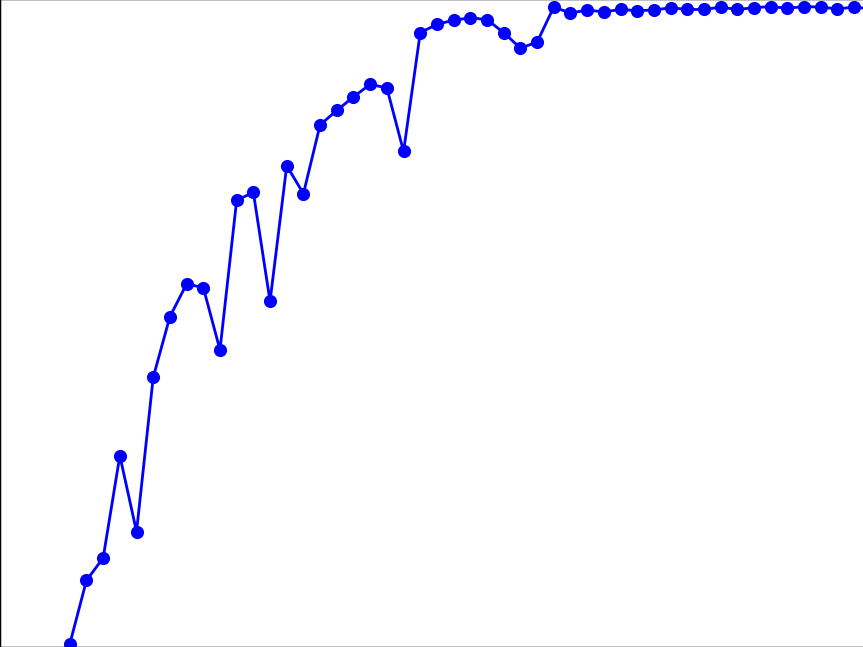

Text(0, 0.5, 'Accuracy')

In [37]:
%matplotlib notebook
x=list(range(1,5001))
y=[i * 100 for i in accuracies]
fig=plt.figure()
# plt.plot(x, y, marker='o', color = 'blue')
ax=fig.add_axes([0,0,1,1])
ax.plot(x, y, '-ok', color = 'blue')
ax.set_title("Accuracy progression through 50 Epochs")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')